In [1]:
import pandas as pd
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
def read_tab_file(filename):
    '''
    The output of the MTP shotgun pipeline includes a '.tab' file which lists the abundances and the taxonomies. 
    This method parses it to a dict
    '''
    out = {}
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith(">>>"):
                name = line.split(' ')[1]
                out[name] = {}
            elif re.findall('^[a-zA-Z]+', line[0]):
                try:
                    taxon, cg_reads, abud, taxonomy = line.rstrip().split('\t')
                except ValueError:
                    taxon, cg_reads, abud = line.rstrip().split('\t')
                    taxonomy = ''
                out[name][taxon] = [int(cg_reads), float(abud), taxonomy]
    return out

def get_count_df(tabpath, taxonomy_info={}):
    samp_name = tabpath.split('/')[-1].split('.')[0]
    level_dict = read_tab_file(tabpath)
    species_dict = level_dict['Species']

    if not species_dict:
        print(f'No results for {samp_name}')
        return None, taxonomy_info

    species_df = pd.DataFrame.from_dict(species_dict, orient='index')
    species_df.columns = ['Core Gene Reads', 'Abundance', 'Taxonomy']
    
    cg_df = species_df[['Abundance']]
    cg_df.columns = [samp_name]
    
    return cg_df

def make_df(files):
    counts = []
    for file in files:
        count_df = get_count_df(file, {})
        counts.append(count_df)
    return pd.concat(counts, axis=1).fillna(0)

In [3]:
slp_files = glob.glob('../slp/*/*.tab')
noslp_files = glob.glob('../noslp/*/*.tab')

slp_df = make_df(slp_files)
noslp_df = make_df(noslp_files)
sum_slp_df = slp_df.sum(axis=1)
sum_noslp_df = noslp_df.sum(axis=1)
sum_slp_df = sum_slp_df.sort_values(ascending=False)
sum_noslp_df = sum_noslp_df.sort_values(ascending=False)

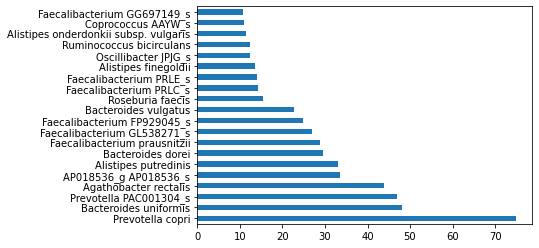

In [4]:
sum_slp_df.head(20).plot(kind='barh')
plt.show()

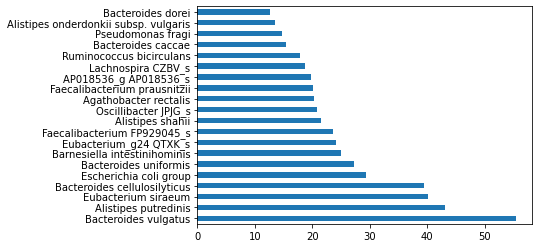

In [5]:
sum_noslp_df.head(20).plot(kind='barh')
plt.show()

In [6]:
slp_set = set(sum_slp_df.index)
noslp_set = set(sum_noslp_df.index)
exc_slp_set = slp_set - noslp_set
exc_noslp_set = noslp_set - slp_set
exc_slp_df = sum_slp_df[list(exc_slp_set)] #passing uncasted set is deprecated
exc_noslp_df = sum_noslp_df[list(exc_noslp_set)]
exc_slp_df = exc_slp_df.sort_values(ascending=False)
exc_noslp_df = exc_noslp_df.sort_values(ascending=False)

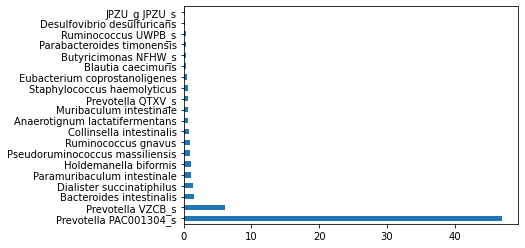

In [7]:
exc_slp_df.head(20).plot(kind='barh')
plt.show()

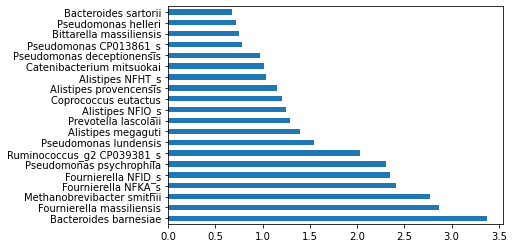

In [8]:
exc_noslp_df.head(20).plot(kind='barh')
plt.show()

<AxesSubplot:>

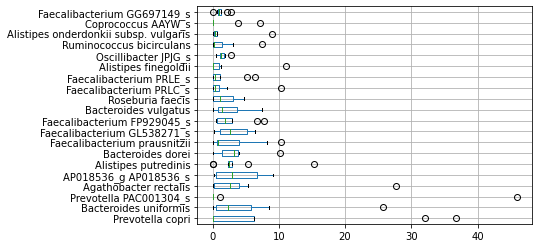

In [9]:
top_slp = sum_slp_df.head(20).index
slp_df.loc[top_slp].T.boxplot(vert=False)

<AxesSubplot:>

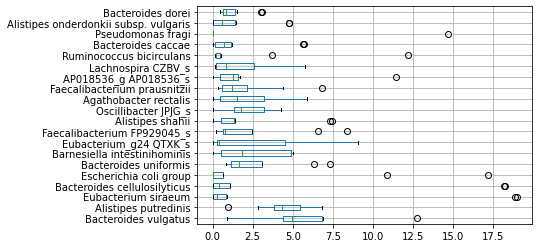

In [10]:
top_noslp = sum_noslp_df.head(20).index
noslp_df.loc[top_noslp].T.boxplot(vert=False)

C:\Users\juno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


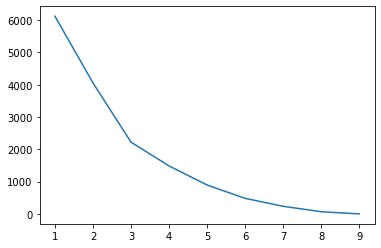

In [11]:
inertias = []
for x in range(1, 10):
    kmeans = KMeans(n_clusters=x)
    kmeans.fit(slp_df.T)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,10),inertias)

C:\Users\juno\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


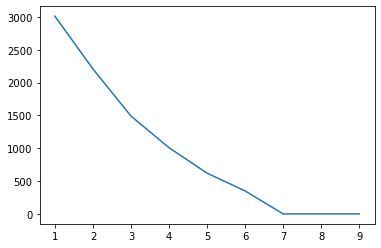

In [12]:
inertias = []
for x in range(1, 10):
    kmeans = KMeans(n_clusters=x)
    kmeans.fit(noslp_df.T)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,10),inertias)

In [15]:
slp_kmeans = KMeans(n_clusters=5)
slp_clusters = slp_kmeans.fit_predict(slp_df.T)
slp_centroids = slp_kmeans.cluster_centers_
slp_clusters

array([3, 1, 2, 0, 4, 0, 0, 0, 1])

In [16]:
noslp_kmeans = KMeans(n_clusters=5)
noslp_clusters = noslp_kmeans.fit_predict(noslp_df.T)
noslp_centroids = noslp_kmeans.cluster_centers_
noslp_clusters

array([0, 3, 1, 2, 4, 0, 1, 3, 1, 2])

0 [-4.37275265  2.12100775  1.90563265  1.36501093] [ -3.40087151  -8.56517823 -10.44395921  -9.1416587 ]
1 [-23.39334007 -19.56960569] [18.35068762 15.32073118]
2 [35.83553915] [23.38415019]
3 [1.96582596] [-14.90770154]
4 [4.14268196] [-10.59619981]


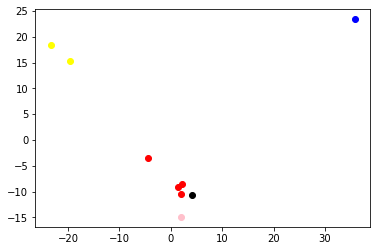

In [17]:
slppca = PCA(2).fit_transform(slp_df.T)
labels = np.unique(slp_clusters)
colors = ['red', 'yellow', 'blue', 'pink', 'black']
for i in labels:
    print(i, slppca[slp_clusters==i, 0], slppca[slp_clusters==i, 1])
    plt.scatter(slppca[slp_clusters==i, 0], slppca[slp_clusters==i, 1], c=colors[i])

0 [-1.51712204  1.6802632 ] [11.55698902 10.88614294]
1 [-1.91607799 -2.98307145 -1.91792314] [2.08708027 4.66697821 2.08570743]
2 [15.26106041 15.34763273] [-8.97688304 -9.0575409 ]
3 [-13.39483846 -13.45904374] [-10.24646717 -10.30830305]
4 [2.89912047] [7.3062963]


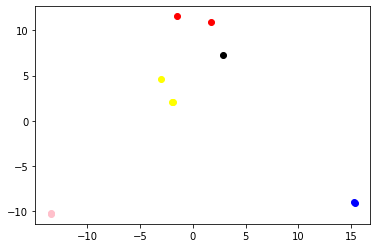

In [18]:
noslppca = PCA(2).fit_transform(noslp_df.T)
labels = np.unique(noslp_clusters)
for i in labels:
    print(i, noslppca[noslp_clusters==i, 0], noslppca[noslp_clusters==i, 1])
    plt.scatter(noslppca[noslp_clusters==i, 0], noslppca[noslp_clusters==i, 1], c=colors[i])